This notebook demonstrates how to add post-processing after the gradient updates.

In [1]:
import tensorflow as tf
def custom_loss(y_actual, y_pred):
    pred_rank = tf.rank(y_pred)
    if pred_rank > 1:
        return tf.math.reduce_sum(1/((y_actual - y_pred - 1)**2 + 0.6) - 1/((y_actual - y_pred + 1)**2 + 0.6),axis=tf.range(1,tf.rank(y_pred)))
    else:
        return 1/((y_actual - y_pred - 1)**2 + 0.6) - 1/((y_actual - y_pred + 1)**2 + 0.6)

The custom loss function is minimized when the model predicts an output 1 larger than the actual (ground truth) output. The loss function is maximized when the model predicts 1 less than actual.

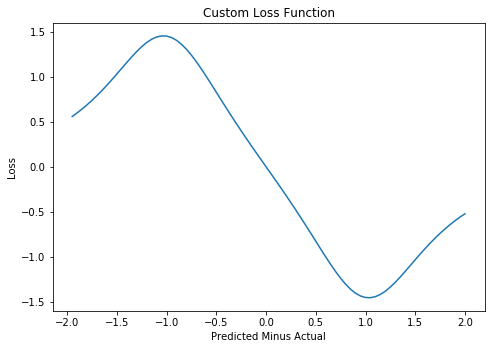

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

y_actual = np.arange(-2,2,0.05)
y_predicted = np.zeros(y_actual.shape)

fig = plt.figure()
axs = fig.add_axes([0,0,1,1])
#loss = lambda act,pred: np.array([custom_loss(act[ii],pred[ii]) for ii in range(act.shape[0])])

axs.plot(y_predicted - y_actual,custom_loss(y_actual,y_predicted))
axs.set_title('Custom Loss Function')
axs.set_ylabel('Loss')
axs.set_xlabel('Predicted Minus Actual')

In this example, there is no post gradient computations. The network correctly finds that by adding 1 to the input, the loss is minimized.

In [3]:
import tensorflow as tf
import numpy as np

class AddVar(tf.keras.layers.Layer):
    def __init__(*args,**kwargs):
        tf.keras.layers.Layer.__init__(*args,**kwargs)
    def build(self,input_shape):
        self.bias = tf.Variable(initial_value=tf.zeros(input_shape[-1]),trainable=True,dtype=self.dtype)
    def call(self,inputs):
        return inputs + self.bias

inputs = tf.keras.layers.Input(shape=(1,))
outputs = AddVar()(inputs)
model = tf.keras.Model(inputs,outputs)
model.compile(loss = custom_loss)
x = np.random.randn(1000,1)
y = x
xval = np.random.randn(100,1)
yval = xval
model.fit(x=x,y=y,batch_size=10,epochs=16,validation_data = (xval,yval))
model.trainable_variables

Epoch 1/16
100/100 [==============================] - 0s 2ms/step - loss: -0.0909 - val_loss: -0.1713
Epoch 2/16
100/100 [==============================] - 0s 810us/step - loss: -0.2503 - val_loss: -0.3316
Epoch 3/16
100/100 [==============================] - 0s 939us/step - loss: -0.4130 - val_loss: -0.4971
Epoch 4/16
100/100 [==============================] - 0s 877us/step - loss: -0.5815 - val_loss: -0.6684
Epoch 5/16
100/100 [==============================] - 0s 804us/step - loss: -0.7549 - val_loss: -0.8434
Epoch 6/16
100/100 [==============================] - 0s 825us/step - loss: -0.9295 - val_loss: -1.0162
Epoch 7/16
100/100 [==============================] - 0s 825us/step - loss: -1.0971 - val_loss: -1.1765
Epoch 8/16
100/100 [==============================] - 0s 873us/step - loss: -1.2456 - val_loss: -1.3105
Epoch 9/16
100/100 [==============================] - 0s 913us/step - loss: -1.3606 - val_loss: -1.4039
Epoch 10/16
100/100 [==============================] - 0s 958us/st

[<tf.Variable 'add_var/Variable:0' shape=(1,) dtype=float32, numpy=array([1.0322956], dtype=float32)>]

Finally, this example demonstrates adding a post-gradient process.  The post-gradient process takes the update and reverses its sign, effectively changing the algorithm to gradient ascent. As a result, Tensorflow ends up maximizing the loss.

In [4]:
import tensorflow as tf
import numpy as np

class PostProcess:
    update = {}
    def add_update(varName,update_fun):
        assert varName not in PostProcess.update, "Update function already exists for %r; may be duplicate" % varName
        PostProcess.update[varName] = update_fun
def mysum(x):
    a,b = x
    return a + b

class AddVar(tf.keras.layers.Layer,PostProcess):
    def __init__(*args,**kwargs):
        tf.keras.layers.Layer.__init__(*args,**kwargs)
    def build(self,input_shape):
        self.bias = tf.Variable(initial_value=tf.zeros(input_shape[-1]),trainable=False,dtype=self.dtype)
        self.bias2 = tf.Variable(initial_value=tf.identity(self.bias),trainable=True,dtype=self.dtype)
        PostProcess.add_update(self.bias2.name, self.post_update)
    def call(self,inputs):
        x = (inputs,self.bias2)
        return mysum(x)
    def post_update(self):

        theupdate = self.bias2 - self.bias
        # If "=" is used for assignment, differentiation will fail (in eager execution) or throw an error.
        # The assign operator is required.        
        newBias2 = self.bias2.assign(self.bias - theupdate/2.)
        newBias2 = self.bias2.assign(newBias2 - theupdate/2.)
        return [self.bias.assign(newBias2)]

class CustomTrainModel(tf.keras.Model):
    def train_step(self,data):
        myoutputs = tf.keras.Model.train_step(self,data)
        for tv in self.trainable_variables:
            if tv.name in PostProcess.update:
                PostProcess.update[tv.name]()
        return myoutputs

inputs = tf.keras.layers.Input(shape=(1,))
outputs = AddVar()(inputs)
model = CustomTrainModel(inputs,outputs)
model.compile(loss = custom_loss,run_eagerly=False)
x = np.random.randn(1000,1)
y = x
xval = np.random.randn(100,1)
yval = xval
model.fit(x=x,y=y,batch_size=10,epochs=16,validation_data = (xval,yval))
model.trainable_variables
model.save('This_is_a_model_i_saved.pb')

Epoch 1/16
100/100 [==============================] - 0s 2ms/step - loss: 0.0909 - val_loss: 0.1713
Epoch 2/16
100/100 [==============================] - 0s 960us/step - loss: 0.2503 - val_loss: 0.3316
Epoch 3/16
100/100 [==============================] - 0s 854us/step - loss: 0.4130 - val_loss: 0.4971
Epoch 4/16
100/100 [==============================] - 0s 937us/step - loss: 0.5815 - val_loss: 0.6684
Epoch 5/16
100/100 [==============================] - 0s 758us/step - loss: 0.7549 - val_loss: 0.8434
Epoch 6/16
100/100 [==============================] - 0s 873us/step - loss: 0.9295 - val_loss: 1.0162
Epoch 7/16
100/100 [==============================] - 0s 872us/step - loss: 1.0971 - val_loss: 1.1765
Epoch 8/16
100/100 [==============================] - 0s 865us/step - loss: 1.2456 - val_loss: 1.3105
Epoch 9/16
100/100 [==============================] - 0s 802us/step - loss: 1.3606 - val_loss: 1.4039
Epoch 10/16
100/100 [==============================] - 0s 802us/step - loss: 1.4299 

In [3]:
import tensorflow as tf
import numpy as np

class PostProcess:
    update = {}
    def add_update(varName,update_fun):
        assert varName not in PostProcess.update, "Update function already exists for %r; may be duplicate" % varName
        PostProcess.update[varName] = update_fun
def mysum(x):
    return x[0] + x[1]

class AddVar(tf.keras.layers.Layer,PostProcess):
    def __init__(*args,**kwargs):
        tf.keras.layers.Layer.__init__(*args,**kwargs)
    def build(self,input_shape):
        self.bias = tf.Variable(initial_value=tf.zeros(input_shape[-1]),trainable=False,dtype=self.dtype)
        self.bias2 = tf.Variable(initial_value=tf.identity(self.bias),trainable=True,dtype=self.dtype)
        PostProcess.add_update(self.bias2.name, self.post_update)
    def call(self,inputs):
        x = []
        x.append(inputs)
        x.append(self.bias2)
        return mysum(x)
    def post_update(self):

        theupdate = self.bias2 - self.bias
        # If "=" is used for assignment, differentiation will fail (in eager execution) or throw an error.
        # The assign operator is required.        
        newBias2 = self.bias2.assign(self.bias - theupdate)
        return [self.bias.assign(newBias2)]

class CustomTrainModel(tf.keras.Model):
    def train_step(self,data):
        myoutputs = tf.keras.Model.train_step(self,data)
        for tv in self.trainable_variables:
            if tv.name in PostProcess.update:
                PostProcess.update[tv.name]()
        return myoutputs

inputs = tf.keras.layers.Input(shape=(1,))
outputs = AddVar()(inputs)
model = CustomTrainModel(inputs,outputs)
model.compile(loss = custom_loss,run_eagerly=False)
x = np.random.randn(1000,1)
y = x
xval = np.random.randn(100,1)
yval = xval
model.fit(x=x,y=y,batch_size=10,epochs=16,validation_data = (xval,yval))
model.trainable_variables

Epoch 1/16
100/100 [==============================] - 0s 2ms/step - loss: 0.0909 - val_loss: 0.1713
Epoch 2/16
100/100 [==============================] - 0s 946us/step - loss: 0.2503 - val_loss: 0.3316
Epoch 3/16
100/100 [==============================] - 0s 898us/step - loss: 0.4130 - val_loss: 0.4971
Epoch 4/16
100/100 [==============================] - 0s 843us/step - loss: 0.5815 - val_loss: 0.6684
Epoch 5/16
100/100 [==============================] - 0s 839us/step - loss: 0.7549 - val_loss: 0.8434
Epoch 6/16
100/100 [==============================] - 0s 849us/step - loss: 0.9295 - val_loss: 1.0162
Epoch 7/16
100/100 [==============================] - 0s 973us/step - loss: 1.0971 - val_loss: 1.1765
Epoch 8/16
100/100 [==============================] - 0s 864us/step - loss: 1.2456 - val_loss: 1.3105
Epoch 9/16
100/100 [==============================] - 0s 859us/step - loss: 1.3606 - val_loss: 1.4039
Epoch 10/16
100/100 [==============================] - 0s 920us/step - loss: 1.4299 

[<tf.Variable 'add_var/Variable:0' shape=(1,) dtype=float32, numpy=array([-1.0332956], dtype=float32)>]

In [6]:
import tensorflow as tf
import numpy as np

class PostProcess:
    update = {}
    def add_update(varName,update_fun):
        assert varName not in PostProcess.update, "Update function already exists for %r; may be duplicate" % varName
        PostProcess.update[varName] = update_fun
def mysum(x):
    return x[0] + x[1]

class AddVar(tf.keras.layers.Layer,PostProcess):
    def __init__(*args,**kwargs):
        tf.keras.layers.Layer.__init__(*args,**kwargs)
    def build(self,input_shape):
        self.bias = tf.Variable(initial_value=tf.zeros(input_shape[0][-1]),trainable=False,dtype=self.dtype)
        self.bias2 = tf.Variable(initial_value=tf.identity(self.bias),trainable=True,dtype=self.dtype)
        PostProcess.add_update(self.bias2.name, self.post_update)
    def call(self,inputs):
        xA,xB = inputs
        return xA + xB + self.bias2
    def post_update(self):

        theupdate = self.bias2 - self.bias
        # If "=" is used for assignment, differentiation will fail (in eager execution) or throw an error.
        # The assign operator is required.        
        newBias2 = self.bias2.assign(self.bias - theupdate)
        return [self.bias.assign(newBias2)]

class CustomTrainModel(tf.keras.Model):
    def train_step(self,data):
        myoutputs = tf.keras.Model.train_step(self,data)
        for tv in self.trainable_variables:
            if tv.name in PostProcess.update:
                PostProcess.update[tv.name]()
        return myoutputs

inputA = tf.keras.layers.Input(shape=(1,))
inputB = tf.keras.layers.Input(shape=(1,))
inputs = (inputA,inputB)
outputs = AddVar()(inputs)
model = CustomTrainModel(inputs,outputs)
model.compile(loss = custom_loss,run_eagerly=False)
xA = np.random.randn(1000,1)
xB = np.random.randn(1000,1)
y = xA + xB
xAval = np.random.randn(100,1)
xBval = np.random.randn(100,1)
yval = xAval + xBval
model.fit(x=(xA,xB),y=y,batch_size=10,epochs=16,validation_data = ((xAval,xBval),yval))
model.trainable_variables

Epoch 1/16
100/100 [==============================] - 0s 2ms/step - loss: 0.0909 - val_loss: 0.1713
Epoch 2/16
100/100 [==============================] - 0s 971us/step - loss: 0.2503 - val_loss: 0.3316
Epoch 3/16
100/100 [==============================] - 0s 946us/step - loss: 0.4130 - val_loss: 0.4971
Epoch 4/16
100/100 [==============================] - 0s 875us/step - loss: 0.5815 - val_loss: 0.6684
Epoch 5/16
100/100 [==============================] - 0s 950us/step - loss: 0.7549 - val_loss: 0.8434
Epoch 6/16
100/100 [==============================] - 0s 959us/step - loss: 0.9295 - val_loss: 1.0162
Epoch 7/16
100/100 [==============================] - 0s 898us/step - loss: 1.0971 - val_loss: 1.1765
Epoch 8/16
100/100 [==============================] - 0s 970us/step - loss: 1.2456 - val_loss: 1.3105
Epoch 9/16
100/100 [==============================] - 0s 894us/step - loss: 1.3606 - val_loss: 1.4039
Epoch 10/16
100/100 [==============================] - 0s 896us/step - loss: 1.4299 

[<tf.Variable 'add_var_3/Variable:0' shape=(1,) dtype=float32, numpy=array([-1.0332959], dtype=float32)>]